In [1]:
# @title Importing dependencies
import numpy
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from transformers import get_cosine_schedule_with_warmup

/home/stuti/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title Downloading MNIST dataset
mnist_train = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))
mnist_test = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))

In [ ]:
# # @title Binarise MNIST data
# def binarise_mnist(mnist):
#     mnist_bin = []
#     for img, label in mnist:
#         mnist_bin.append((torch.where(img < 0.5, 0.0, 1.0), label))
#     return mnist_bin

In [ ]:
# X_train = binarise_mnist(mnist_train)
# X_test = binarise_mnist(mnist_test)

In [ ]:
# # @title Visualise MNIST and binarised MNIST
# import matplotlib.pyplot as plt

# # Get an example image and label from mnist_train
# img, label = mnist_train[0]

# # Get the corresponding binarised image and label from X_train
# binarised_img, binarised_label = X_train[0]

# # Create a figure with two subplots
# fig, axes = plt.subplots(1, 2)

# # Plot the regular MNIST image on the first subplot
# axes[0].imshow(img.squeeze(), cmap='gray')
# axes[0].set_title('Regular MNIST')

# # Plot the binarised MNIST image on the second subplot
# axes[1].imshow(binarised_img.squeeze(), cmap='gray')
# axes[1].set_title('Binarised MNIST')

# # Show the plot
# plt.show()

In [3]:
class CroppedConvolution2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple):
        super(CroppedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)

    def forward(self, X):
        X = self.conv(X)
        out = X[:, :, 1:-self.kernel_height, :]
        up_shifted_out = X[:, :, :-self.kernel_height-1, :]
        return out, up_shifted_out

In [4]:
class MaskedConvolution2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple, mask_type: str):
        super(MaskedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.mask_type = mask_type
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)
        self.create_mask()

    def create_mask(self):
        mask = torch.ones(self.kernel_height, self.kernel_width)
        mask[self.kernel_height // 2, self.kernel_width // 2:] = 0
        mask[self.kernel_height // 2 + 1:, :] = 0
        if self.mask_type == 'B':
            mask[self.kernel_height // 2, self.kernel_width // 2] = 1
        self.register_buffer('mask', mask)

    def forward(self, X):
        self.conv.weight.data = self.conv.weight.data * self.mask
        return self.conv(X)

In [5]:
class CausalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super(CausalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.vertical_to_horizontal = nn.Conv2d(in_channels=2*out_channels,
                                                out_channels=2*out_channels,
                                                kernel_size=(1, 1))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='A')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='A')

    def forward(self, X):
        out_vertical_fc = self.vertical_fc(X)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(X)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)

        out_horizontal_conv = self.horizontal_conv(X)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        out_horizontal = self.horizontal_fc(out_horizontal)

        return out_vertical, out_horizontal

In [6]:
class GatedBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super(GatedBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_to_horizontal = MaskedConvolution2D(in_channels=2*out_channels,
                                                          out_channels=2*out_channels,
                                                          kernel_size=(1, 1),
                                                          padding=(0, 0),
                                                          mask_type='B')

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='B')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.horizontal_skip = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.label_embedding = nn.Embedding(10, 2*out_channels) # 10 embeddings for 10 MNIST classes

    def forward(self, X):
        in_vertical, in_horizontal, label, skip = X['in_vertical'], X['in_horizontal'], X['label'], X['skip']
        label_embedding = self.label_embedding(label).unsqueeze(2).unsqueeze(3)

        out_vertical_fc = self.vertical_fc(in_vertical)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(in_vertical)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv + label_embedding
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)
        out_vertical += in_vertical

        out_horizontal_conv = self.horizontal_conv(in_horizontal)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal + label_embedding
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        skip += self.horizontal_skip(out_horizontal)
        out_horizontal = self.horizontal_fc(out_horizontal)
        out_horizontal += in_horizontal

        return {'in_vertical': out_vertical,
                'in_horizontal': out_horizontal,
                'label': label,
                'skip': skip}

In [7]:
class GatedPixelCNN(nn.Module):
    def __init__(self, in_channels: int, kernel_size: int, hidden_layers: int, hidden_channels: int, out_hidden_channels: int):
        super(GatedPixelCNN, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.hidden_layers = hidden_layers
        self.hidden_channels = hidden_channels
        self.out_hidden_channels = out_hidden_channels

        self.causal_block = CausalBlock(in_channels=in_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=kernel_size)

        self.gated_blocks = nn.Sequential(
            *[GatedBlock(in_channels=hidden_channels,
                         out_channels=hidden_channels,
                         kernel_size=kernel_size) for _ in range(self.hidden_layers)]
        )

        self.label_embedding = nn.Embedding(10, hidden_channels)

        self.hidden_conv = MaskedConvolution2D(in_channels=hidden_channels,
                                               out_channels=out_hidden_channels,
                                               kernel_size=(1, 1),
                                               padding=(0, 0),
                                               mask_type='B')

        self.out_conv = MaskedConvolution2D(in_channels=out_hidden_channels,
                                               out_channels=4*in_channels,    # Output should be an image of same channels as input
                                               kernel_size=(1, 1),
                                               padding=(0, 0),
                                               mask_type='B')

    def forward(self, X, label):
        out_vertical, out_horizontal = self.causal_block(X)

        out = self.gated_blocks({'in_vertical': out_vertical,
                                          'in_horizontal': out_horizontal,
                                          'label': label,
                                          'skip': X.new_zeros(X.size()[0], self.hidden_channels, X.size()[2], X.size()[3])})['skip']

        label_embedding = self.label_embedding(label).unsqueeze(2).unsqueeze(3)

        out += label_embedding
        out = F.relu(out)
        out = self.hidden_conv(out)
        out = F.relu(out)
        out = self.out_conv(out)
        return out

    def sample(self, image_shape=(1, 28, 28), num_samples=10, labels=None, device="cpu"):
        self.eval()

        samples = torch.zeros((num_samples, *image_shape), device=device)  # Start with blank images
        if labels is None:
            labels = torch.randint(high=10, size=(num_samples,)).to(device)
        else:
            labels = (labels * torch.ones(num_samples)).to(device).long()

        with torch.inference_mode():  # No need to compute gradients
            for i in range(image_shape[1]):  # Iterate over height (rows)
                for j in range(image_shape[2]):  # Iterate over width (columns)
                    # Get model prediction for the current (incomplete) image
                    out = self.forward(samples, labels)  # Forward pass through PixelCNN
                    probs = torch.softmax(out[:, :, i, j], dim=1)  # Get probability for current pixel

                    # Sample value based on predicted probability
                    sampled_pixel = torch.multinomial(probs, 1).squeeze(1)  # 1 with prob=probs, else 0

                    # Assign the sampled value to the image
                    samples[:, 0, i, j] = sampled_pixel

        return samples.cpu()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
torch.manual_seed(42)
model = GatedPixelCNN(in_channels=1,
                      kernel_size=7,
                      hidden_layers=5,
                      hidden_channels=16,
                      out_hidden_channels=16)
model.to(device)
img, label = mnist_train[0]
img = img.unsqueeze(0).to(device)
label = torch.tensor(label).unsqueeze(0).to(device)
out = model(img, label)
sample = model.sample((1, 28, 28), 1, 7, device=device)
img.shape, out.shape, sample.shape

(torch.Size([1, 1, 28, 28]),
 torch.Size([1, 4, 28, 28]),
 torch.Size([1, 1, 28, 28]))

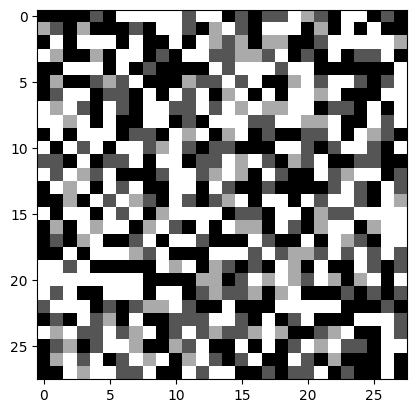

In [12]:
plt.imshow(sample.squeeze().detach().numpy(), cmap='gray')
plt.show()

## Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# @title Creating DataLoader for MNIST
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [11]:
# @title Training loop
torch.manual_seed(42)
epochs = 20

model = GatedPixelCNN(in_channels=1,
                      kernel_size=7,
                      hidden_layers=10,
                      hidden_channels=80,
                      out_hidden_channels=16)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser, max_lr=1e-3, total_steps=epochs*len(train_loader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)
# scheduler = get_cosine_schedule_with_warmup(
#     optimiser,
#     num_warmup_steps=5 * len(train_loader),       # 5 epochs warmup
#     num_training_steps=epochs * len(train_loader))

model.to(device)
model.train()
for epoch in range(epochs):
    loss = 0
    for img, labels in tqdm(train_loader):
        img = img.to(device)
        labels = labels.to(device)
        pixel_targets = torch.clamp((img * 4).long(), max=3)

        optimiser.zero_grad()
        y = model(pixel_targets.float(), labels)
        batch_loss = criterion(y, pixel_targets.squeeze(1))
        loss += batch_loss.item()
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()
    scheduler.step()
    print(f"\nEpoch: {epoch+1}, Loss: {loss / len(train_loader)}")

100%|██████████| 1875/1875 [01:58<00:00, 15.86it/s]



Epoch: 1, Loss: 0.2243805679321289


100%|██████████| 1875/1875 [01:58<00:00, 15.77it/s]



Epoch: 2, Loss: 0.1747960030714671


100%|██████████| 1875/1875 [01:59<00:00, 15.74it/s]



Epoch: 3, Loss: 0.16854645427862802


100%|██████████| 1875/1875 [01:59<00:00, 15.74it/s]



Epoch: 4, Loss: 0.16548290011882782


100%|██████████| 1875/1875 [01:58<00:00, 15.76it/s]



Epoch: 5, Loss: 0.1633965699593226


100%|██████████| 1875/1875 [01:58<00:00, 15.76it/s]



Epoch: 6, Loss: 0.16183790742556253


100%|██████████| 1875/1875 [01:58<00:00, 15.77it/s]



Epoch: 7, Loss: 0.16058711105187734


100%|██████████| 1875/1875 [01:58<00:00, 15.76it/s]



Epoch: 8, Loss: 0.15946533603668214


100%|██████████| 1875/1875 [01:56<00:00, 16.06it/s]



Epoch: 9, Loss: 0.15855247679551443


100%|██████████| 1875/1875 [01:56<00:00, 16.03it/s]



Epoch: 10, Loss: 0.15773443055947622


100%|██████████| 1875/1875 [01:58<00:00, 15.77it/s]



Epoch: 11, Loss: 0.15687523896694183


100%|██████████| 1875/1875 [01:58<00:00, 15.87it/s]



Epoch: 12, Loss: 0.15610713794231415


100%|██████████| 1875/1875 [01:57<00:00, 15.90it/s]



Epoch: 13, Loss: 0.1553661284685135


100%|██████████| 1875/1875 [01:58<00:00, 15.82it/s]



Epoch: 14, Loss: 0.15463594948450723


100%|██████████| 1875/1875 [01:58<00:00, 15.79it/s]



Epoch: 15, Loss: 0.15380683432420095


100%|██████████| 1875/1875 [01:59<00:00, 15.74it/s]



Epoch: 16, Loss: 0.15310099597771962


100%|██████████| 1875/1875 [01:59<00:00, 15.66it/s]



Epoch: 17, Loss: 0.1523134396870931


100%|██████████| 1875/1875 [01:59<00:00, 15.76it/s]



Epoch: 18, Loss: 0.151452046195666


100%|██████████| 1875/1875 [01:58<00:00, 15.80it/s]



Epoch: 19, Loss: 0.15067074333826702


100%|██████████| 1875/1875 [01:57<00:00, 15.98it/s]


Epoch: 20, Loss: 0.14975139920314154


In [12]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'conditional_4_way_pixelcnn_model_epochs_20.pth')

torch.save(optimiser.state_dict(), 'conditional_4_way_pixelcnn_optimiser_epochs_20.pth')

In [11]:
# @title Sample images

model = GatedPixelCNN(in_channels=1,
                      kernel_size=7,
                      hidden_layers=10,
                      hidden_channels=80,
                      out_hidden_channels=16)  # Create an instance of your model

model.load_state_dict(torch.load('conditional_4_way_pixelcnn_model_epochs_5.pth')) # Load the saved state dictionary
model.to(device)

GatedPixelCNN(
  (causal_block): CausalBlock(
    (vertical_fc): Conv2d(1, 160, kernel_size=(1, 1), stride=(1, 1))
    (vertical_conv): CroppedConvolution2D(
      (conv): Conv2d(1, 160, kernel_size=(4, 7), stride=(1, 1), padding=(4, 3))
    )
    (vertical_to_horizontal): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
    (horizontal_conv): MaskedConvolution2D(
      (conv): Conv2d(1, 160, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
    )
    (horizontal_fc): MaskedConvolution2D(
      (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (gated_blocks): Sequential(
    (0): GatedBlock(
      (vertical_fc): Conv2d(80, 160, kernel_size=(1, 1), stride=(1, 1))
      (vertical_to_horizontal): MaskedConvolution2D(
        (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
      )
      (vertical_conv): CroppedConvolution2D(
        (conv): Conv2d(80, 160, kernel_size=(4, 7), stride=(1, 1), padding=(4, 3))
      )
      (horizontal_conv): MaskedConvoluti

In [ ]:
generated_images = model.sample(num_samples=100, device=device)

# Plot the 100 images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

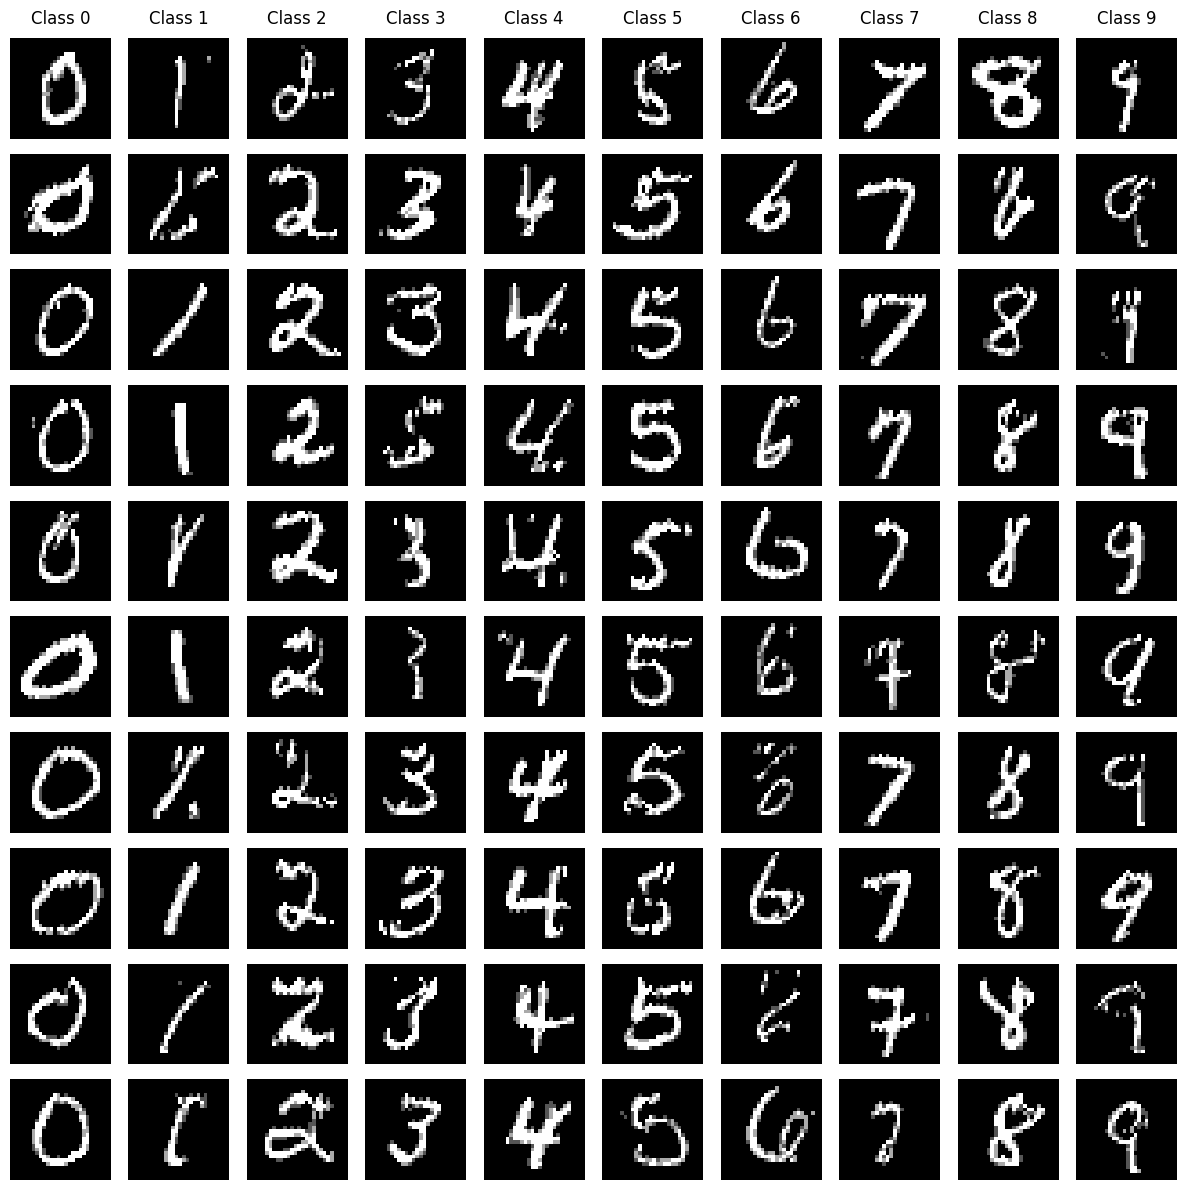

In [13]:
import torch
import matplotlib.pyplot as plt

num_classes = 10
num_samples_per_class = 10

# 1) Generate all samples
#    We'll store them in a list-of-lists so that
#    generated_images[col][row] is sample `row` of class `col`.
generated_images = []
for class_label in range(num_classes):
    class_images = model.sample(
        num_samples=num_samples_per_class,
        labels=torch.full((num_samples_per_class,), class_label, dtype=torch.long),
        device=device
    )
    generated_images.append(class_images)  # index by class → column

# 2) Plot in a grid with classes as columns
fig, axes = plt.subplots(num_samples_per_class, num_classes, figsize=(12, 12))

for col in range(num_classes):
    for row in range(num_samples_per_class):
        ax = axes[row, col]
        img = generated_images[col][row].squeeze().cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    # 3) Label the **top** of each column
    axes[0, col].set_title(f"Class {col}", size='large', pad=10)

plt.tight_layout()
plt.show()

In [15]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|          causal_block.vertical_fc.weight          |    160     |
|           causal_block.vertical_fc.bias           |    160     |
|       causal_block.vertical_conv.conv.weight      |    4480    |
|        causal_block.vertical_conv.conv.bias       |    160     |
|     causal_block.vertical_to_horizontal.weight    |   25600    |
|      causal_block.vertical_to_horizontal.bias     |    160     |
|      causal_block.horizontal_conv.conv.weight     |    1120    |
|       causal_block.horizontal_conv.conv.bias      |    160     |
|       causal_block.horizontal_fc.conv.weight      |    6400    |
|        causal_block.horizontal_fc.conv.bias       |     80     |
|         gated_blocks.0.vertical_fc.weight         |   12800    |
|          gated_blocks.0.vertical_fc.bias          |    160  

5056644

In [14]:
import math
import torch
import torch.nn as nn

def compute_bits_per_dim(model, data_loader, device):
    """
    Computes the average bits per dimension (bits/dim) for a given model and dataset.
    This function uses binary cross-entropy as the negative log likelihood (in nats)
    and converts it to bits by dividing by log(2).
    """
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()
    total_loss = 0.0
    total_elements = 0
    with torch.inference_mode():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            batch_size = imgs.shape[0]
            # For MNIST, each image is 28x28 so number of pixels per sample:
            num_pixels = imgs.shape[2] * imgs.shape[3]

            pixel_targets = torch.clamp((imgs * 4).long(), max=3)
            output = model(pixel_targets.float(), labels)
            
            # Compute the BCE loss (sum over all pixels)
            loss = criterion(output, pixel_targets.squeeze(1))
            total_loss += loss.item()
            total_elements += batch_size * num_pixels

    # Average negative log-likelihood (in nats per pixel)
    average_nll = total_loss / total_elements
    # Convert nats to bits (1 nat = 1/log(2) bits)
    bits_per_dim = average_nll / math.log(2)
    return average_nll, bits_per_dim

average_nll, bits_dim = compute_bits_per_dim(model, test_loader, device)
print(f"Average NLL (nats per pixel): {average_nll}")
print(f"Bits per dim: {bits_dim}")

Average NLL (nats per pixel): 0.16163638788340043
Bits per dim: 0.23319201522658675
